# Month 2 Project: Sales Forecasting for a Retail Chain (by Faiz Hussain)


### Importing Libraries

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Loading the Dataset

In [78]:
df = pd.read_csv('Retail Chain Dataset.csv',)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [79]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')

There are 9800 rows and 18 columns


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [81]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [83]:
df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales
count,9800.000000,9800,9800,9789.000000,9800.000000
mean,4900.500000,2017-05-01 05:13:51.673469440,2017-05-05 04:17:52.653061120,55273.322403,230.769059
min,1.000000,2015-01-03 00:00:00,2015-01-07 00:00:00,1040.000000,0.444000
25%,2450.750000,2016-05-24 00:00:00,2016-05-27 18:00:00,23223.000000,17.248000
50%,4900.500000,2017-06-26 00:00:00,2017-06-29 00:00:00,58103.000000,54.490000
75%,7350.250000,2018-05-15 00:00:00,2018-05-19 00:00:00,90008.000000,210.605000
max,9800.000000,2018-12-30 00:00:00,2019-01-05 00:00:00,99301.000000,22638.480000
std,2829.160653,NaN,NaN,32041.223413,626.651875


In [84]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [85]:
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [86]:
df[df['Postal Code'].isnull() == True]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
2234,2235,CA-2018-104066,2018-12-05,2018-12-10,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,5275,CA-2016-162887,2016-11-07,2016-11-09,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,8799,US-2017-150140,2017-04-06,2017-04-10,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,9147,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,9148,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9148,9149,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9386,9387,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9387,9388,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9388,9389,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,9390,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04


In [87]:
mask = (df['City'] == 'Burlington') & (df['State'] == 'Vermont') & (df['Postal Code'].isna())

df.loc[mask, 'Postal Code'] = 5401

In [88]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

In [89]:
df.duplicated().sum()

np.int64(0)

In [90]:
df.drop('Row ID', axis = 1, inplace = True)

In [91]:
### Sales Trend over Time

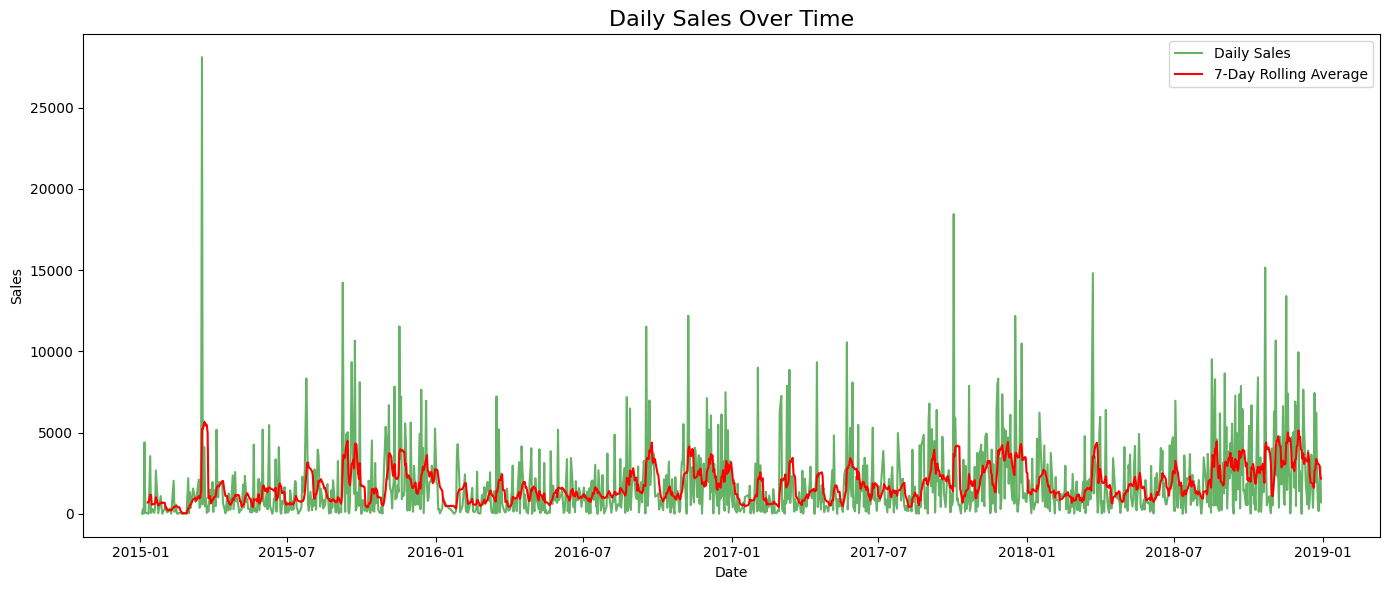

In [92]:
plt.figure(figsize=(14, 6))

# Group by order date and sum sales
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

# Sort by date to ensure correct plotting
daily_sales.sort_values('Order Date', inplace=True)

# Plot daily sales
plt.plot(daily_sales['Order Date'], daily_sales['Sales'], label='Daily Sales', color='green', alpha=0.6)


# Add rolling average (7-day)
daily_sales['Rolling Avg'] = daily_sales['Sales'].rolling(window=7).mean()
plt.plot(daily_sales['Order Date'], daily_sales['Rolling Avg'], color='red', label='7-Day Rolling Average')

# Titles and labels
plt.title("Daily Sales Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

### Yearly sales Trend Analysis

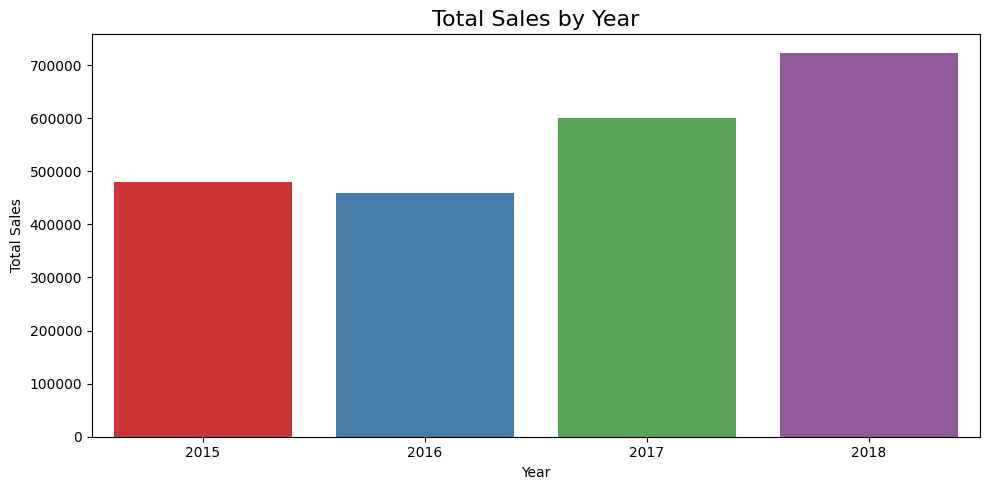

In [93]:
df['Year'] = df['Order Date'].dt.year
    
# Aggregate sales by year
yearly_sales = df.groupby('Year')['Sales'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=yearly_sales, x='Year', y='Sales', palette='Set1')

# Labels and titles
plt.title("Total Sales by Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

### Regional Sales Analysis

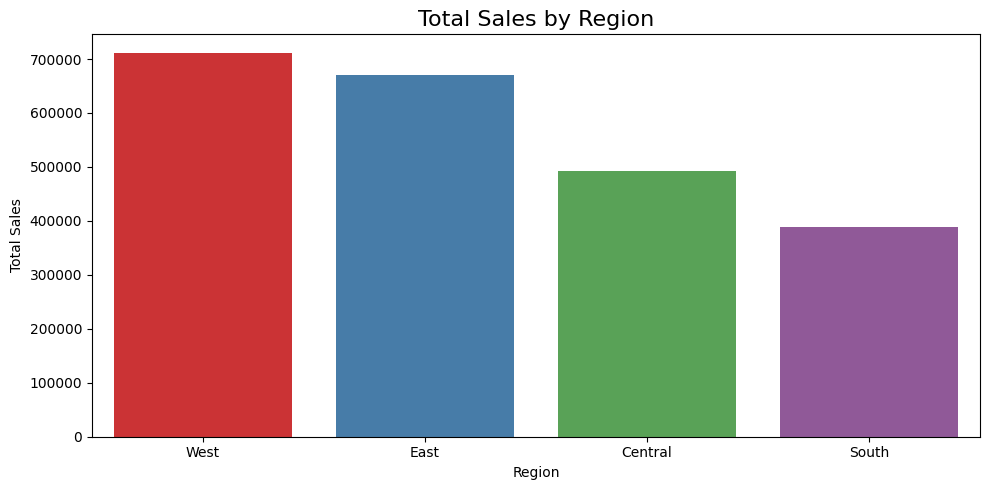

In [94]:
# Group sales by Region
region_sales = df.groupby('Region')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=region_sales, x='Region', y='Sales', palette='Set1')

# Labels and title
plt.title("Total Sales by Region", fontsize=16)
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

### Category & Sub-Category Sales Analysis

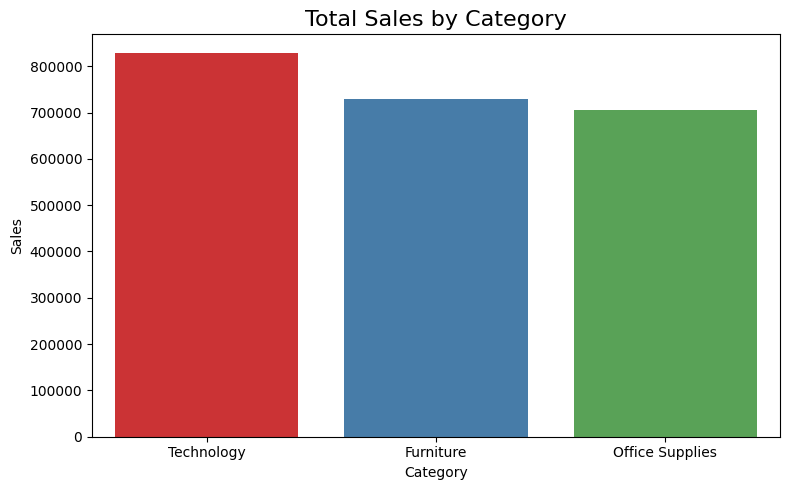

In [95]:
# Total Sales by Category
category_sales = df.groupby('Category')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=category_sales, x='Category', y='Sales', palette='Set1')
plt.title("Total Sales by Category", fontsize=16)
plt.xlabel("Category")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

### Total Sales by Sub-Category

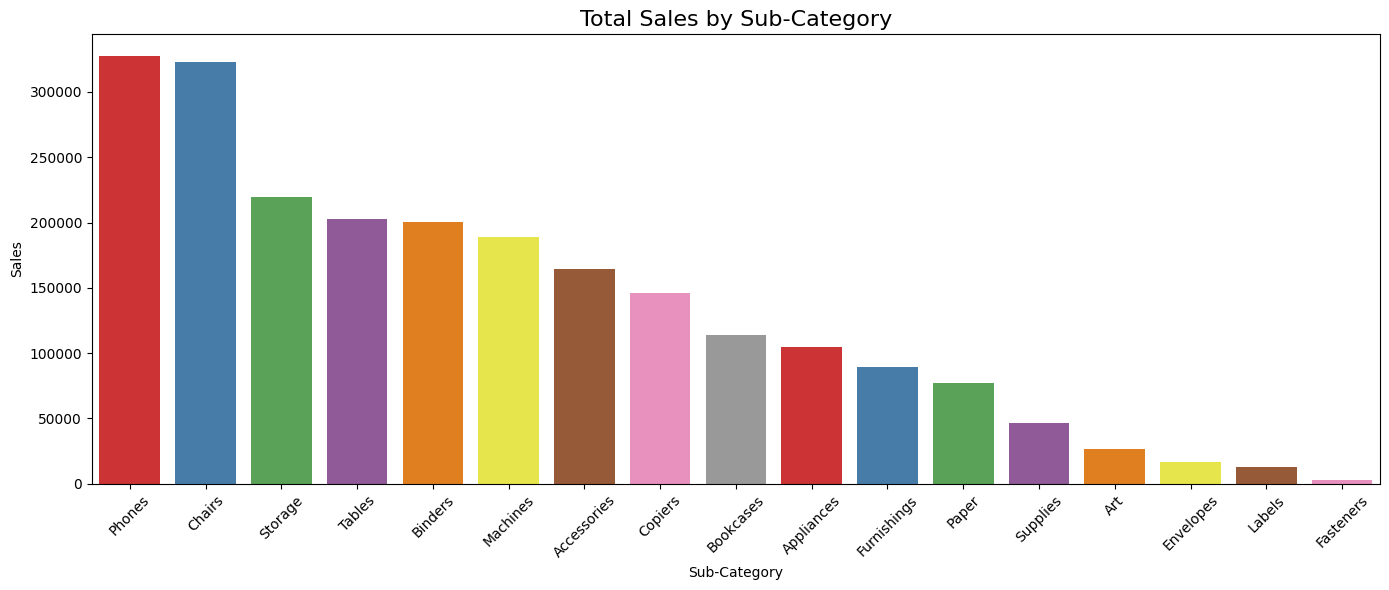

In [96]:
# Total Sales by Sub-Category
subcat_sales = df.groupby('Sub-Category')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=subcat_sales, x='Sub-Category', y='Sales', palette='Set1')
plt.title("Total Sales by Sub-Category", fontsize=16)
plt.xlabel("Sub-Category")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Customer Segment Analysis

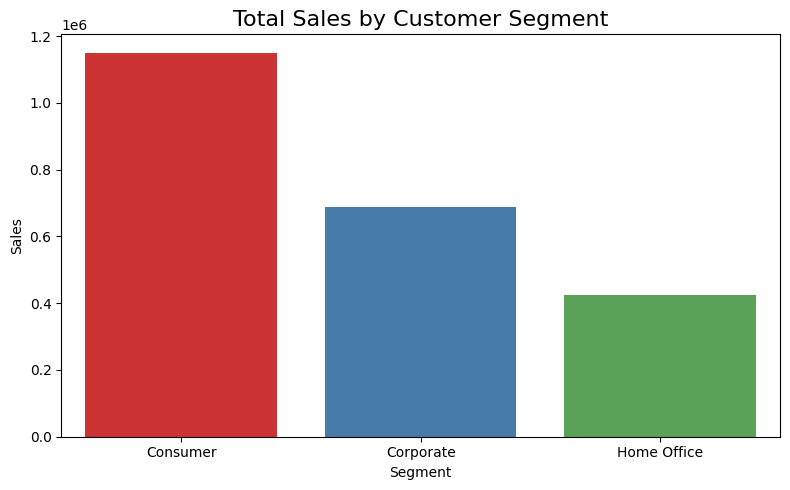

In [97]:
# Total Sales by Customer Segment
segment_sales = df.groupby('Segment')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=segment_sales, x='Segment', y='Sales', palette='Set1')

# Labels and title
plt.title("Total Sales by Customer Segment", fontsize=16)
plt.xlabel("Segment")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

### Heat map

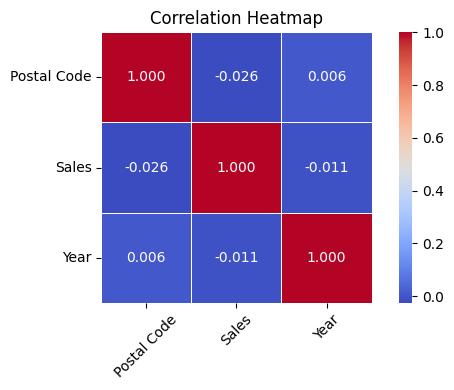

In [98]:
plt.figure(figsize=(6, 4))  # Smaller size (width=6, height=4)

sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    cmap='coolwarm',         # Change color map (try 'viridis', 'Blues', etc.)
    linewidths=0.5,          # Adds grid lines
    fmt=".3f",               # Show 3 decimal points
    square=True              # Make cells square-shaped
)

plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


### Decomposition

In [99]:
monthly_sales = df.groupby(['Order Date', 'Region'])['Sales'].sum().unstack().resample('M').sum() 

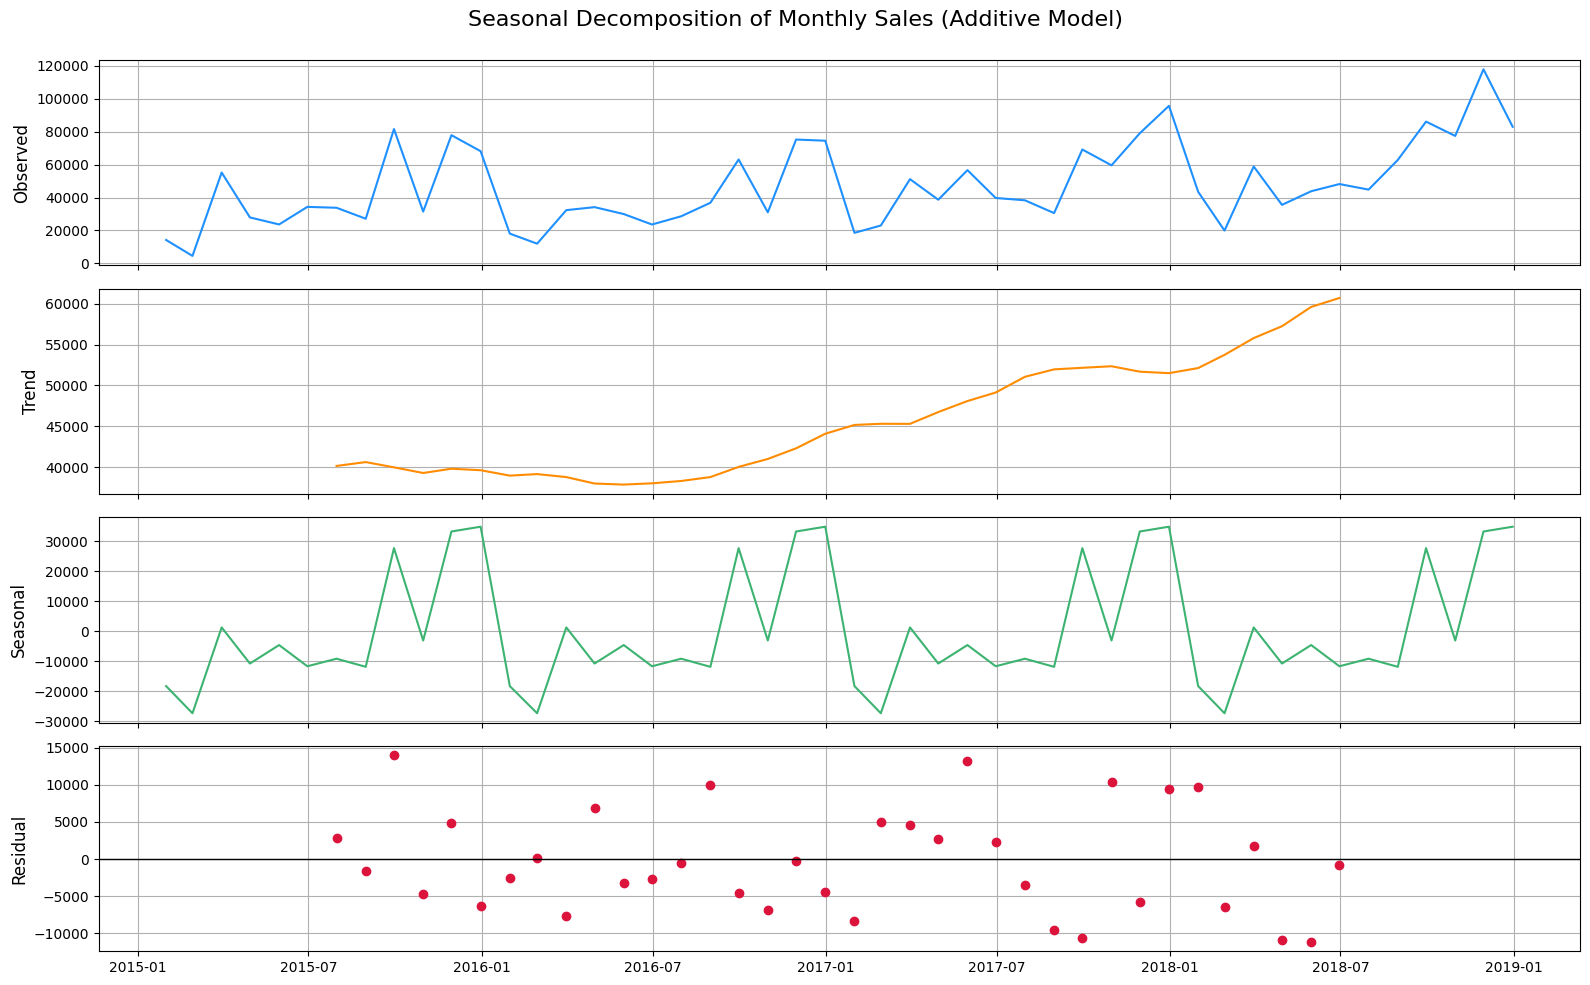

In [100]:
# Decompose
result = seasonal_decompose(monthly_sales.sum(axis=1), model='additive')

# Plot each component separately with custom styling
fig, axes = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

# Observed
axes[0].plot(result.observed, color='dodgerblue')
axes[0].set_ylabel('Observed', fontsize=12)

# Trend
axes[1].plot(result.trend, color='darkorange')
axes[1].set_ylabel('Trend', fontsize=12)

# Seasonal
axes[2].plot(result.seasonal, color='mediumseagreen')
axes[2].set_ylabel('Seasonal', fontsize=12)

# Residual
axes[3].plot(result.resid, marker='o', linestyle='', color='crimson')
axes[3].axhline(0, color='black', linewidth=1)
axes[3].set_ylabel('Residual', fontsize=12)

# Common settings
for ax in axes:
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

plt.suptitle('Seasonal Decomposition of Monthly Sales (Additive Model)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # leave room for title
plt.show()

### ACF/PACF

<Figure size 1200x600 with 0 Axes>

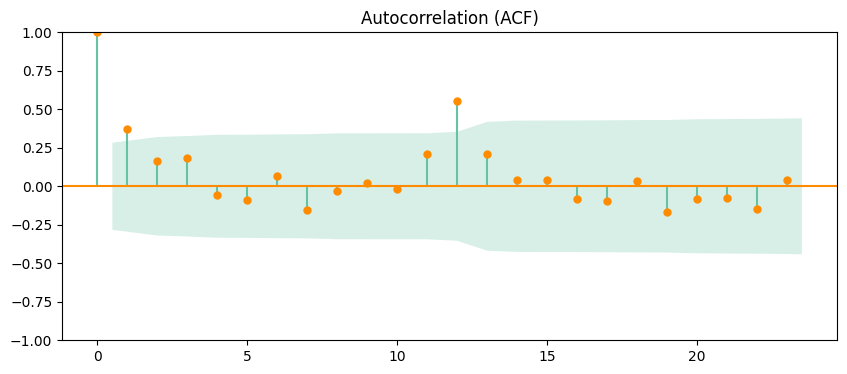

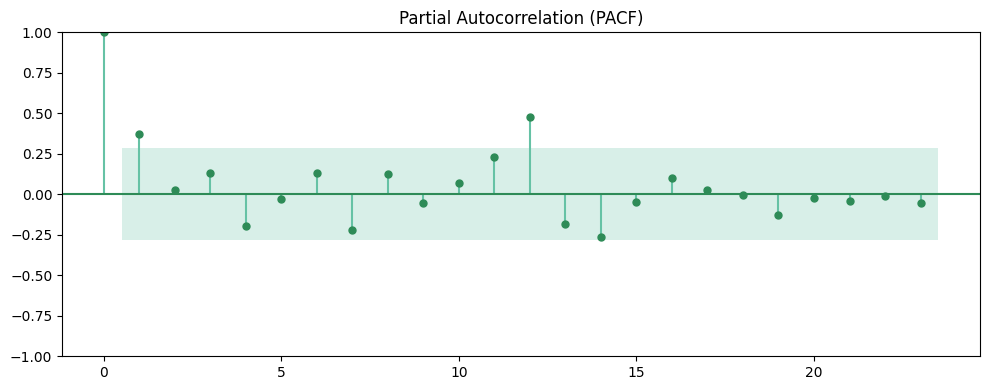

In [101]:
# Set figure size
plt.figure(figsize=(12, 6))

# ACF plot
fig_acf = plot_acf(
    monthly_sales.sum(axis=1),
    lags=23,
    alpha=0.05,
    title="Autocorrelation (ACF)",
    color='darkorange'
)
fig_acf.set_size_inches(10, 4)  # Optional: Resize ACF separately

# PACF plot
fig_pacf = plot_pacf(
    monthly_sales.sum(axis=1),
    lags=23,
    alpha=0.05,
    title="Partial Autocorrelation (PACF)",
    color='seagreen'
)
fig_pacf.set_size_inches(10, 4)  # Optional: Resize PACF separately

plt.tight_layout()
plt.show()

### Timeseries Forecasting

In [102]:
monthly_sales = df.groupby([pd.Grouper(key='Order Date', freq='M'), 'Region', 'Category'])['Sales'].sum().reset_index()
overall_sales = monthly_sales.groupby('Order Date')['Sales'].sum().reset_index()
overall_sales['Order Date'] = pd.to_datetime(overall_sales['Order Date'])
overall_sales = overall_sales.set_index('Order Date')
overall_sales.index.freq = 'M'

In [103]:
# train test split
train = overall_sales[:'2017-12-31']
test = overall_sales['2018-01-01':]

#### SARIMA

In [104]:
# Fit SARIMA Model (Manual order tuning or use auto_arima for best params)
sarima_model = SARIMAX(train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()

# Forecast for Test Period
sarima_forecast = sarima_results.get_forecast(steps=len(test))
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

#### Prophet

In [105]:
# Prepare Data for Prophet
prophet_df = train.reset_index().rename(columns={'Order Date': 'ds', 'Sales': 'y'})

prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Create Future DataFrame
future_dates = prophet_model.make_future_dataframe(periods=len(test), freq='M')
prophet_forecast = prophet_model.predict(future_dates)

# Extract Predictions and Confidence Intervals for Test Period
prophet_pred = prophet_forecast.set_index('ds').loc[test.index]['yhat']
prophet_ci_lower = prophet_forecast.set_index('ds').loc[test.index]['yhat_lower']
prophet_ci_upper = prophet_forecast.set_index('ds').loc[test.index]['yhat_upper']

17:33:04 - cmdstanpy - INFO - Chain [1] start processing
17:33:04 - cmdstanpy - INFO - Chain [1] done processing


#### Evaluation

In [106]:
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Evaluate SARIMA
evaluate_model(test['Sales'], sarima_pred, 'SARIMA')

# Evaluate Prophet
evaluate_model(test['Sales'], prophet_pred, 'Prophet')

SARIMA - MAE: 13930.02, RMSE: 16394.82, MAPE: 27.77%
Prophet - MAE: 9839.79, RMSE: 14133.07, MAPE: 15.67%


#### Forecast Plots

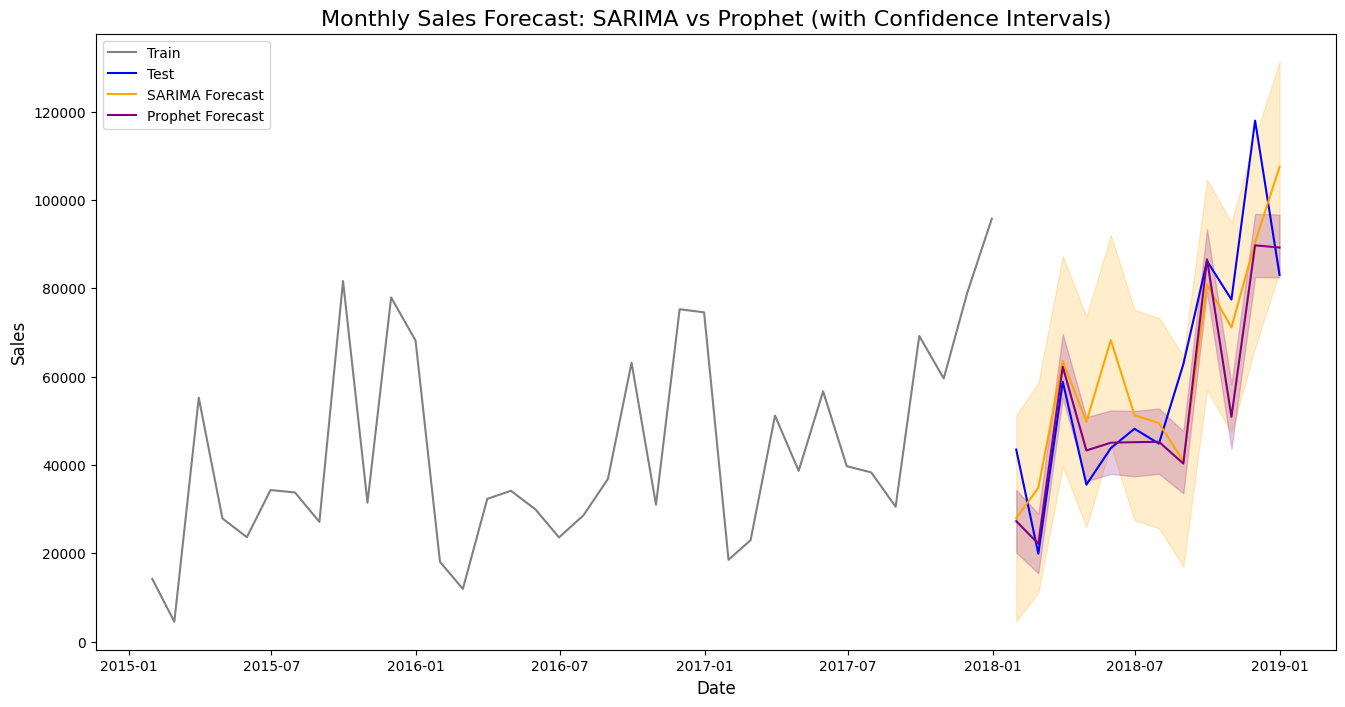

In [107]:
plt.figure(figsize=(16, 8))  # Bigger figure size for better visibility

# Train and Test plots
plt.plot(train.index, train['Sales'], label='Train', color='gray')
plt.plot(test.index, test['Sales'], label='Test', color='blue')

# SARIMA forecast (orange)
plt.plot(test.index, sarima_pred, label='SARIMA Forecast', color='orange')
plt.fill_between(test.index, sarima_ci['lower Sales'], sarima_ci['upper Sales'], color='orange', alpha=0.2)

# Prophet forecast (purple)
plt.plot(test.index, prophet_pred, label='Prophet Forecast', color='purple')
plt.fill_between(test.index, prophet_ci_lower, prophet_ci_upper, color='purple', alpha=0.2)

# Labels, legend, title
plt.legend()
plt.title('Monthly Sales Forecast: SARIMA vs Prophet (with Confidence Intervals)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


In [108]:
forecast_output = pd.DataFrame({
    'Date': test.index,
    'Actual Sales': test['Sales'].values,
    'SARIMA Forecast': sarima_pred.values,
    'Prophet Forecast': prophet_pred.values
})


In [76]:
region_category_sales = monthly_sales[(monthly_sales['Order Date'] >= test.index.min()) & (monthly_sales['Order Date'] <= test.index.max())]
forecast_output = forecast_output.merge(region_category_sales, left_on='Date', right_on = 'Order Date', how='left')

forecast_output.to_csv('forecast_output.csv', index=False)
print("Forecast output exported to forecast_output.csv")


Forecast output exported to forecast_output.csv
